**GOALS**:
- Use a pre-trained CNN features to evaluate classification feasibility.
- Train a classifier on those features if it seems promising.
- Use data augmentation.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
from tqdm import tqdm
import data_science_functions as ds
import project_tools as pt

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


**Table of contents**<a id='toc0_'></a>    
- 1. [Images and labels.](#toc1_)    
- 2. [Evaluate feasibility with the VGG16 model used for feature extraction.](#toc2_)    
  - 2.1. [Download the model](#toc2_1_)    
  - 2.2. [Extract features from the model](#toc2_2_)    
  - 2.3. [Evaluate classification feasibility with a t-SNE visualization.](#toc2_3_)    
- 3. [Evaluate feasibility with the lighter MobileNet model.](#toc3_)    
  - 3.1. [Download the model and drop the last layers](#toc3_1_)    
  - 3.2. [Extract features from the model](#toc3_2_)    
  - 3.3. [Evaluate classification feasibility with a t-SNE visualization.](#toc3_3_)    
- 4. [Supervised classification](#toc4_)    
  - 4.1. [Preparing the directories for TF compatibility](#toc4_1_)    
  - 4.2. [Filter corrupted images](#toc4_2_)    
  - 4.3. [Generate train and evaluation sets](#toc4_3_)    
  - 4.4. [Datasets pre-processing and data augmentation](#toc4_4_)    
  - 4.5. [ Define functions to create, compile and save models from the mobilenet model.](#toc4_5_)    
  - 4.6. [Classification model without augmentation](#toc4_6_)    
  - 4.7. [Classification model based on mobileNet WITH data augmentation.](#toc4_7_)    
  - 4.8. [Classification model based on mobileNet with data augmentation + dropout 0.3](#toc4_8_)    
  - 4.9. [Classification model based on mobileNet with data augmentation + dropout 0.5](#toc4_9_)    
  - 4.10. [Visualize results](#toc4_10_)    
- 5. [Regularizations](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>Images and labels.

In [19]:
metadata_filename = './data/Flipkart/Images/metadata.csv.gz'
metadata = pd.read_csv(metadata_filename)
metadata.head()

,image,shape,n_pixels,mean_gray,min_gray,max_gray,category
0,009099b1f6e1e8f893ec29a7023153c4.jpg,"(1162, 687, 3)",798294,172.415863,0,255,watches
1,0096e89cc25a8b96fb9808716406fe94.jpg,"(904, 1478, 3)",1336112,156.565580,0,255,kitchen_&_dining
2,00cbbc837d340fa163d11e169fbdb952.jpg,"(326, 1347, 3)",439122,192.004357,9,255,home_furnishing
3,00d84a518e0550612fcfcba3b02b6255.jpg,"(857, 1100, 3)",942700,168.342569,0,255,beauty_and_personal_care
4,00e966a5049a262cfc72e6bbf68b80e7.jpg,"(1100, 962, 3)",1058200,171.585655,3,255,computers


# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Evaluate feasibility with the VGG16 model used for feature extraction.

## 2.1.  [&#9650;](#toc0_) <a id='toc2_1_'></a>Download the model

In [20]:
base_model = VGG16(weights="imagenet")
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 2.2.  [&#9650;](#toc0_) <a id='toc2_2_'></a>Extract features from the model

In [21]:
images_features = []
image_dir = './data/Flipkart/Images/'

for name in tqdm(metadata.image):
    image = load_img(os.path.join(image_dir, name), target_size=(224, 224))
    # Note : it is possible to keep image ratio in load_img
    input_arr = img_to_array(image) 
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = preprocess_input(input_arr)
    images_features.append(model.predict(input_arr, verbose=0)[0])

images_features = np.asarray(images_features)
images_features.shape


  1%|          | 13/1050 [00:08<11:43,  1.47it/s]


KeyboardInterrupt: 

## 2.3.  [&#9650;](#toc0_) <a id='toc2_3_'></a>Evaluate classification feasibility with a t-SNE visualization.

In [ ]:
print(images_features.shape)
pca = PCA(n_components=0.99)
X_pca= pca.fit_transform(images_features)
print(f'reduced to {pca.n_components_} dimensions.')

(1050, 4096)
reduced to 803 dimensions.


In [ ]:
import time

t0 = time.time()

tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

duration = time.time() - t0
print("T-SNE took : ", "%3.2f" % duration, "secondes")

T-SNE took :  4.34 secondes


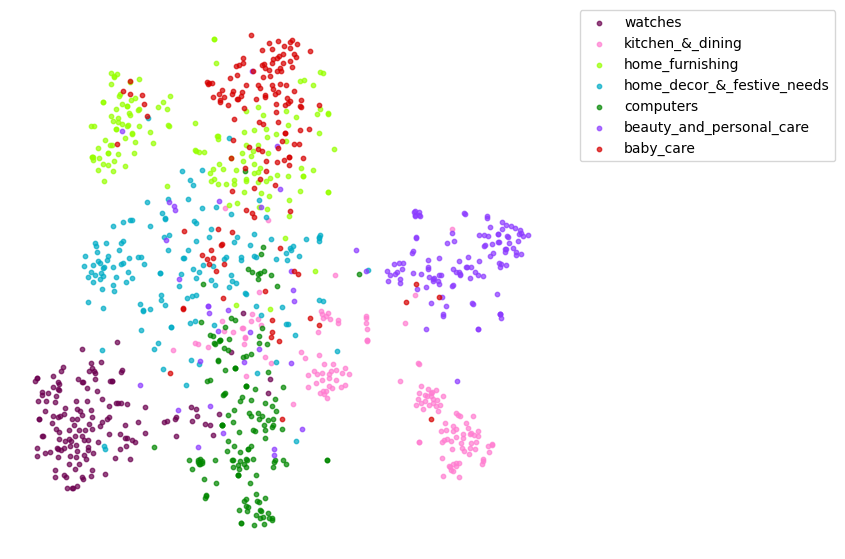

In [ ]:
ds.display_tsne(X_tsne, illustrative_var=metadata.category)

The VGG16 returns much more relevant features than what we got from SIFT and ORB for the classification task we are willing to do.

Let's evaluate scores we would obtain if we try unsupervised classifications :

In [ ]:
kmeans = KMeans(n_clusters=7, n_init=5)
pca = PCA(n_components=0.99)
tsne = TSNE(n_components=2, perplexity=30)

pipelines = {
    'kmeans': make_pipeline(kmeans),
    'pca_kmeans': make_pipeline(pca, kmeans),
    'tsne_kmeans': make_pipeline(tsne, kmeans),
}


true_labels = metadata.category

# Results containers
evaluations = []
evaluations_std = []

for pipe_name, pipe in pipelines.items():
    
    model_name = (
        pipe_name 
        + '\non VGG16 features'
    )
    
    print('***********')
    print(model_name)
    ds.fit_and_evaluate_clusters(
        model=pipe,
        X=images_features,
        labels=true_labels,
        name=model_name,
        evaluations=evaluations,
        evaluations_std=evaluations_std,
    ) 

***********
kmeans
on VGG16 features
clustering done in 1.45 ± 0.13 s 
Homogeneity: 0.575 ± 0.010
Completeness: 0.605 ± 0.015
V-measure: 0.590 ± 0.012
Adjusted Rand-Index: 0.465 ± 0.018
Silhouette: 0.086 ± 0.002
***********
pca_kmeans
on VGG16 features
clustering done in 2.42 ± 0.11 s 
Homogeneity: 0.579 ± 0.010
Completeness: 0.609 ± 0.016
V-measure: 0.594 ± 0.013
Adjusted Rand-Index: 0.471 ± 0.020
Silhouette: 0.086 ± 0.002
***********
tsne_kmeans
on VGG16 features
clustering done in 6.15 ± 0.43 s 
Homogeneity: 0.555 ± 0.002
Completeness: 0.565 ± 0.002
V-measure: 0.560 ± 0.002
Adjusted Rand-Index: 0.447 ± 0.001
Silhouette: 0.074 ± 0.000


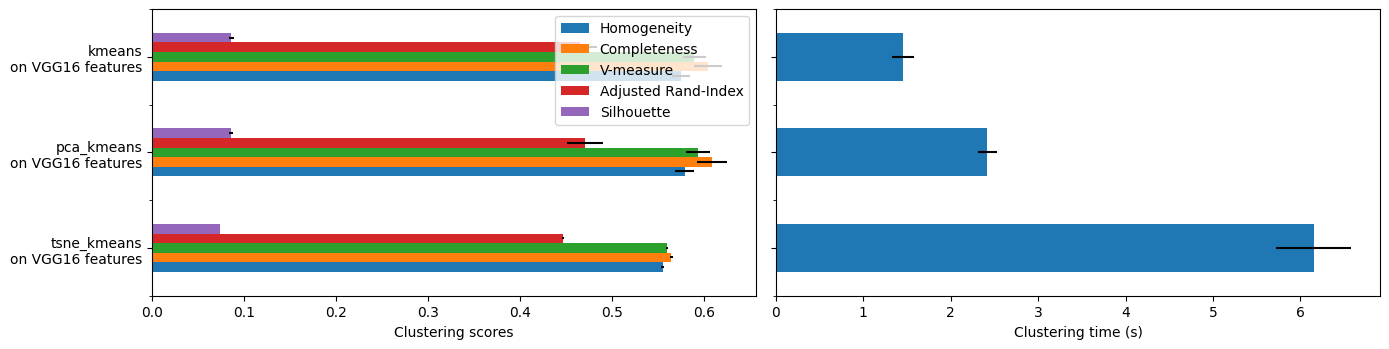

In [ ]:
ds.display_clusters_scores(evaluations, evaluations_std)

The t-SNE visual and those scores prove the feasibility of classifying. Let's save those features in a dataframe for later use, and let's try to supervise a classifier.

In [ ]:
img_fts = pd.DataFrame(
    images_features,
    index=metadata.image,
)
print(img_fts.shape)
img_fts.head()

(1050, 4096)


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
image,,,,,,,,,,,,,,,,,,,,,
009099b1f6e1e8f893ec29a7023153c4.jpg,2.591889,2.726005,0.000000,3.297257,1.653290,0.000000,0.000000,0.000000,0.0,2.143805,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.869046,0.000000,2.940915
0096e89cc25a8b96fb9808716406fe94.jpg,0.000000,0.000000,0.000000,2.216237,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.00000,0.000000,0.0,1.620237,2.385922,0.045931,0.399317,0.000000,0.157195,2.914562
00cbbc837d340fa163d11e169fbdb952.jpg,0.000000,0.000000,0.000000,2.043372,0.000000,0.498197,2.621285,0.000000,0.0,0.000000,...,2.97961,0.008590,0.0,1.337796,0.000000,3.764513,0.000000,0.708812,0.000000,0.000000
00d84a518e0550612fcfcba3b02b6255.jpg,0.000000,0.000000,0.000000,0.000000,0.146764,0.000000,0.000000,1.364243,0.0,1.564342,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.578789
00e966a5049a262cfc72e6bbf68b80e7.jpg,0.000000,0.000000,1.530867,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.00000,0.526205,0.0,0.053459,0.000000,1.196185,0.145275,0.000000,0.000000,3.437492


In [ ]:
img_fts.to_csv('VGG16_features.csv.gz')

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Evaluate feasibility with the lighter MobileNet model.

## 3.1.  [&#9650;](#toc0_) <a id='toc3_1_'></a>Download the model and drop the last layers

In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()
model = Model(inputs=mobile.inputs, outputs=mobile.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

## 3.2.  [&#9650;](#toc0_) <a id='toc3_2_'></a>Extract features from the model

In [ ]:
images_features = []
image_dir = './data/Flipkart/Images/'

for name in tqdm(metadata.image):
    image = load_img(os.path.join(image_dir, name), target_size=(224, 224))
    input_arr = img_to_array(image) 
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = tf.keras.applications.mobilenet.preprocess_input(input_arr)
    images_features.append(model.predict(input_arr, verbose=0)[0])

images_features = np.asarray(images_features)
images_features.shape


 32%|███▏      | 337/1050 [00:37<02:02,  5.84it/s]/home/louberehc/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1050/1050 [02:12<00:00,  7.92it/s]


(1050, 1000)

In [ ]:
metadata.iloc[335:338, :]

,image,shape,n_pixels,mean_gray,min_gray,max_gray,category
335,54749618b728306f9b3dc518dec315ee.jpg,"(581, 400, 3)",232400,172.012794,0,255,watches
336,54754ccd18f2a75c53de68806176392a.jpg,"(809, 1100, 3)",889900,243.298399,57,255,computers
337,5479bb7028827d60000720a2c135976a.jpg,"(1000, 302, 3)",302000,84.091812,0,255,watches


## 3.3.  [&#9650;](#toc0_) <a id='toc3_3_'></a>Evaluate classification feasibility with a t-SNE visualization.

In [ ]:
print(images_features.shape)
pca = PCA(n_components=0.99)
X_pca= pca.fit_transform(images_features)
print(f'reduced to {pca.n_components_} dimensions.')

(1050, 1000)
reduced to 406 dimensions.


In [ ]:
import time

t0 = time.time()

tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

duration = time.time() - t0
print("T-SNE took : ", "%3.2f" % duration, "secondes")

T-SNE took :  4.89 secondes


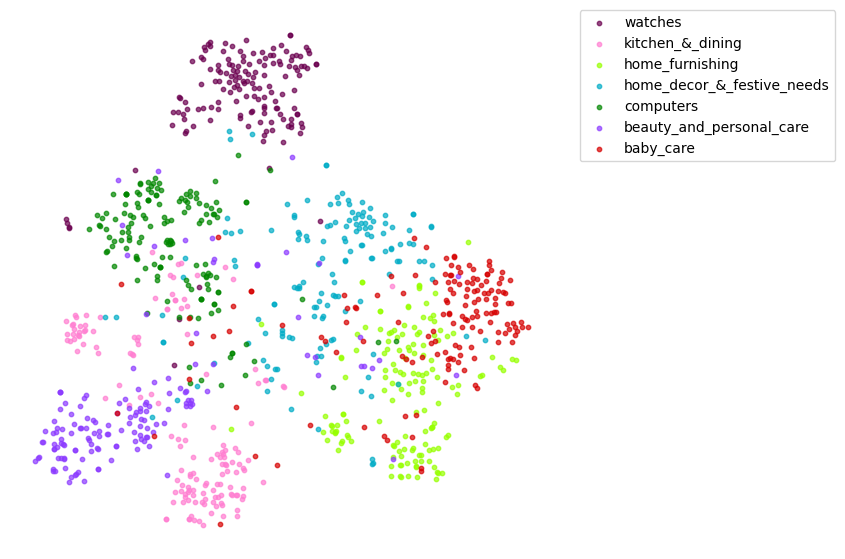

In [ ]:
ds.display_tsne(X_tsne, illustrative_var=metadata.category)

The MobileNet model also nice results.

Let's evaluate scores we would obtain if we try unsupervised classifications :

In [ ]:
kmeans = KMeans(n_clusters=7, n_init=5)
pca = PCA(n_components=0.99)
tsne = TSNE(n_components=2, perplexity=30)

pipelines = {
    'kmeans': make_pipeline(kmeans),
    'pca_kmeans': make_pipeline(pca, kmeans),
    'tsne_kmeans': make_pipeline(tsne, kmeans),
}


true_labels = metadata.category

# Results containers
evaluations = []
evaluations_std = []

for pipe_name, pipe in pipelines.items():
    
    model_name = (
        pipe_name 
        + '\non MobileNet features'
    )
    
    print('***********')
    print(model_name)
    ds.fit_and_evaluate_clusters(
        model=pipe,
        X=images_features,
        labels=true_labels,
        name=model_name,
        evaluations=evaluations,
        evaluations_std=evaluations_std,
    ) 

***********
kmeans
on MobileNet features
clustering done in 0.59 ± 0.06 s 
Homogeneity: 0.593 ± 0.007
Completeness: 0.602 ± 0.005
V-measure: 0.598 ± 0.006
Adjusted Rand-Index: 0.532 ± 0.018
Silhouette: 0.088 ± 0.000
***********
pca_kmeans
on MobileNet features
clustering done in 0.88 ± 0.09 s 
Homogeneity: 0.598 ± 0.004
Completeness: 0.606 ± 0.006
V-measure: 0.602 ± 0.005
Adjusted Rand-Index: 0.543 ± 0.005
Silhouette: 0.087 ± 0.000
***********
tsne_kmeans
on MobileNet features
clustering done in 5.13 ± 0.51 s 
Homogeneity: 0.576 ± 0.001
Completeness: 0.578 ± 0.001
V-measure: 0.577 ± 0.001
Adjusted Rand-Index: 0.525 ± 0.002
Silhouette: 0.066 ± 0.001


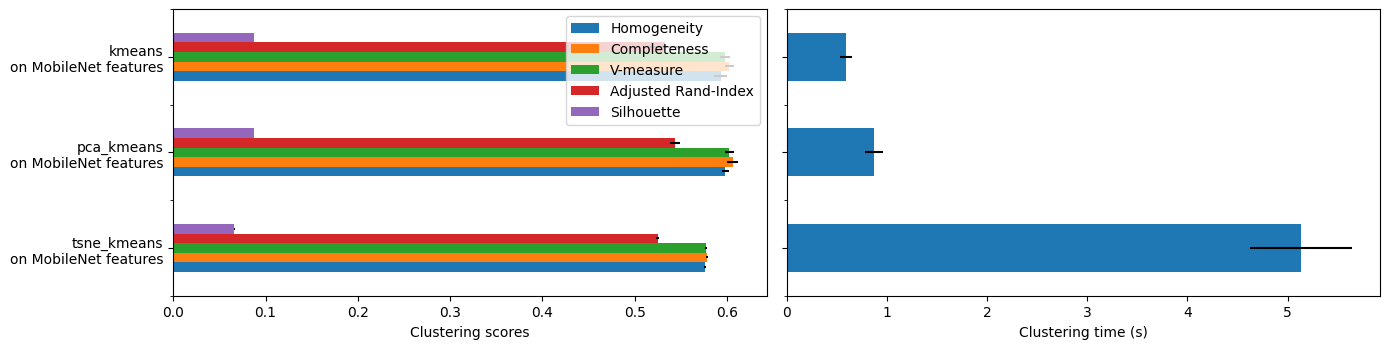

In [ ]:
ds.display_clusters_scores(evaluations, evaluations_std)

We even get better results than VGG16.

As it is a lighter model that provides better results, it is the one I am going to fine-tune in the next section.

# 4.  [&#9650;](#toc0_) <a id='toc4_'></a>Supervised classification

## 4.1.  [&#9650;](#toc0_) <a id='toc4_1_'></a>Preparing the directories for TF compatibility

I first need to create directories compatible with tf.keras.utils.image_dataset_from_directory function.

A main directory with class subdirectories.

Note : Sometimes, it can be convenient to subdivide the main directory into 3 directories (train, eval, test) before filling it with class subdirectories.

In [ ]:
main_dir_name = 'Flipkart_products_images'
if not os.path.exists(main_dir_name):
    os.mkdir(main_dir_name)

In [ ]:
# Format class names
class_names = [cl.replace('&', 'and') for cl in metadata.category.unique()]
class_names 

['watches',
 'kitchen_and_dining',
 'home_furnishing',
 'beauty_and_personal_care',
 'computers',
 'home_decor_and_festive_needs',
 'baby_care']

In [ ]:
for cl in class_names:
    sub_dir = os.path.join(main_dir_name, cl)
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir) 

In [ ]:
!tree ./Flipkart_products_images

./Flipkart_products_images
├── baby_care
├── beauty_and_personal_care
├── computers
├── home_decor_and_festive_needs
├── home_furnishing
├── kitchen_and_dining
└── watches

7 directories, 0 files


In [ ]:
# Load info about images
img_fts = pd.read_csv('VGG16_features.csv.gz', index_col='image')
display(img_fts.head())

metadata = pd.read_csv('./data/Flipkart/Images/metadata.csv.gz')
metadata.head()


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
image,,,,,,,,,,,,,,,,,,,,,
009099b1f6e1e8f893ec29a7023153c4.jpg,2.591889,2.726005,0.000000,3.297257,1.653290,0.000000,0.000000,0.000000,0.0,2.143805,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.869046,0.000000,2.940915
0096e89cc25a8b96fb9808716406fe94.jpg,0.000000,0.000000,0.000000,2.216237,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.00000,0.000000,0.0,1.620237,2.385922,0.045931,0.399317,0.000000,0.157195,2.914562
00cbbc837d340fa163d11e169fbdb952.jpg,0.000000,0.000000,0.000000,2.043372,0.000000,0.498197,2.621285,0.000000,0.0,0.000000,...,2.97961,0.008590,0.0,1.337796,0.000000,3.764512,0.000000,0.708812,0.000000,0.000000
00d84a518e0550612fcfcba3b02b6255.jpg,0.000000,0.000000,0.000000,0.000000,0.146764,0.000000,0.000000,1.364243,0.0,1.564342,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.578789
00e966a5049a262cfc72e6bbf68b80e7.jpg,0.000000,0.000000,1.530867,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.00000,0.526205,0.0,0.053459,0.000000,1.196185,0.145275,0.000000,0.000000,3.437492


,image,shape,n_pixels,mean_gray,min_gray,max_gray,category
0,009099b1f6e1e8f893ec29a7023153c4.jpg,"(1162, 687, 3)",798294,172.415863,0,255,watches
1,0096e89cc25a8b96fb9808716406fe94.jpg,"(904, 1478, 3)",1336112,156.565580,0,255,kitchen_&_dining
2,00cbbc837d340fa163d11e169fbdb952.jpg,"(326, 1347, 3)",439122,192.004357,9,255,home_furnishing
3,00d84a518e0550612fcfcba3b02b6255.jpg,"(857, 1100, 3)",942700,168.342569,0,255,beauty_and_personal_care
4,00e966a5049a262cfc72e6bbf68b80e7.jpg,"(1100, 962, 3)",1058200,171.585655,3,255,computers


In [ ]:
import shutil

original_img_dir = './data/Flipkart/Images/'

# Format category to sub-directory name.
metadata['category'] = metadata.category.str.replace('&', 'and')

for cl_name, cl_df in metadata.groupby('category').__iter__():
    # Build the relative image path.
    cl_img_paths = original_img_dir + cl_df.image
    for img_path in cl_img_paths:
        dst_dir = os.path.join(main_dir_name, cl_name)
        # Copy the image to its class sub-directory
        shutil.copy(img_path, dst_dir)
    print(f'{cl_name} sub directory filled')

baby_care sub directory filled
beauty_and_personal_care sub directory filled
computers sub directory filled
home_decor_and_festive_needs sub directory filled
home_furnishing sub directory filled
kitchen_and_dining sub directory filled
watches sub directory filled


In [ ]:
!tree ./Flipkart_products_images --dirsfirst --filelimit 10

./Flipkart_products_images
├── baby_care  [150 entries exceeds filelimit, not opening dir]
├── beauty_and_personal_care  [150 entries exceeds filelimit, not opening dir]
├── computers  [150 entries exceeds filelimit, not opening dir]
├── home_decor_and_festive_needs  [150 entries exceeds filelimit, not opening dir]
├── home_furnishing  [150 entries exceeds filelimit, not opening dir]
├── kitchen_and_dining  [150 entries exceeds filelimit, not opening dir]
└── watches  [150 entries exceeds filelimit, not opening dir]

7 directories, 0 files


Self-Note : may be I could have used os.symlink because the tf.keras function seems to allow it.

## 4.2.  [&#9650;](#toc0_) <a id='toc4_2_'></a>Filter corrupted images

In [ ]:
import os

num_skipped = 0
for folder_name in class_names:
    folder_path = os.path.join(main_dir_name, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


## 4.3.  [&#9650;](#toc0_) <a id='toc4_3_'></a>Generate train and evaluation sets

In [ ]:
img_width = 224
img_height = 224

def get_ds(batch_size=16, validation_split=0.15):

    ds_params = dict(
        labels='inferred',
        label_mode='categorical',
        class_names=None,
        color_mode='rgb',
        batch_size=batch_size,
        image_size = (img_height, img_width),
        shuffle=True,
        seed=7,
        validation_split=validation_split,
        interpolation='bilinear',
        subset='both',
        follow_links=False,
        crop_to_aspect_ratio=False,
    )
    # label_mode = 'categorical' associate an array of length 7 with a 1 in 
    # the category.
    # if subset = 'both' --> return both dataset.

    # Retrieve both the training and the evaluation datasets.
    train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
        main_dir_name,
        **ds_params,
    )
    
    return train_ds, val_ds

In [28]:
batch_size = 16
validation_split = 0.15

train_ds, val_ds = get_ds(batch_size, validation_split)

# Retrieve class names
class_names = train_ds.class_names
print(f'class names : {class_names}')

Found 1050 files belonging to 7 classes.
Using 893 files for training.
Using 157 files for validation.
class names : ['baby_care', 'beauty_and_personal_care', 'computers', 'home_decor_and_festive_needs', 'home_furnishing', 'kitchen_and_dining', 'watches']


2023-06-13 13:37:08.165541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [893]
	 [[{{node Placeholder/_0}}]]
2023-06-13 13:37:08.166292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [893]
	 [[{{node Placeholder/_0}}]]


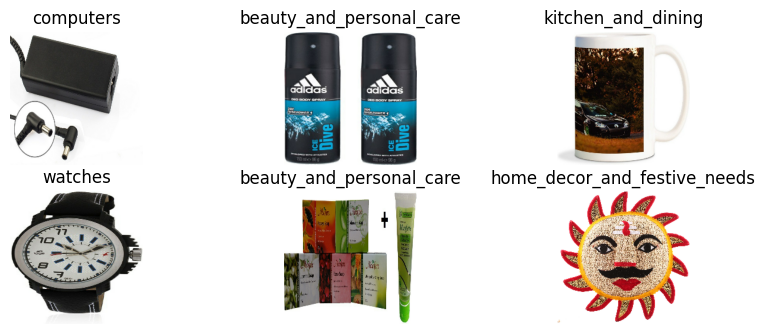

In [29]:
# Visualize first items of the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")


Above, Images are not pre-processed for the mobilenet.

## 4.4.  [&#9650;](#toc0_) <a id='toc4_4_'></a>Datasets pre-processing and data augmentation

There are two ways to proceed data augmentation. It can be integrated to the model (as its first layers) or it can be made via the tf.data API which enables to build complex input pipelines.

It seems that when using a GPU and for simplicity in deploying models, the first way is better. 

Nevertheless, when using a CPU -- my case --, It is better to go with the tf.data.Dataset.

In [30]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ],
    name = 'data_augmentation'
)

In [31]:
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1050

def prepare_ds(ds, shuffle=True, augment=False):
    """ append some step to the ds pipeline :
        - image pre-processing for model compatibility
        - image augmentation for the training set, if `augment`.
        - batch and prefetch. """
    # Prepare the entry to the Mobilenet.
    if shuffle:
        ds = ds.shuffle(BUFFER_SIZE)
    
    # pre-process for the mobilenet model    
    ds = ds.map(
        lambda x, y: (tf.keras.applications.mobilenet.preprocess_input(x), y),
        num_parallel_calls=AUTOTUNE
    )    

    # Use data augmentation if `augment` == True.
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    # Use buffered prefetching.
    return ds.prefetch(AUTOTUNE)


For now, let's not augment the data and see the results.

In [32]:
train_ds = prepare_ds(train_ds, shuffle=True, augment=False)
val_ds = prepare_ds(val_ds)

2023-06-13 13:37:29.754535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [893]
	 [[{{node Placeholder/_4}}]]
2023-06-13 13:37:29.755192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [893]
	 [[{{node Placeholder/_4}}]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] f

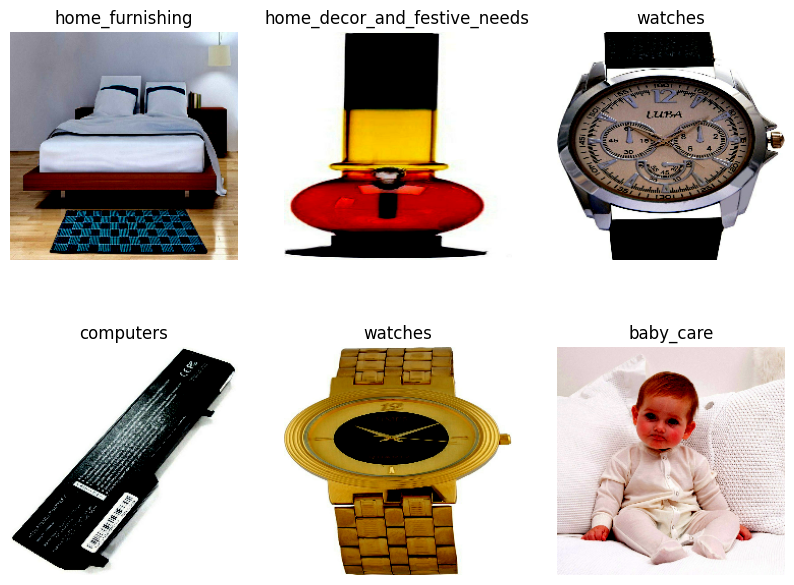

In [33]:
plt.figure(figsize=(10, 7.5))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy(), vmin=-1, vmax=1)
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

## 4.5.  [&#9650;](#toc0_) <a id='toc4_5_'></a> Define functions to create, compile and save models from the mobilenet model.

In [39]:
# define a decreasing lr_schedule strategy
STEPS_PER_EPOCH = 893 // batch_size

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*5,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)


In [80]:
def make_model_from_mobilenet(n_classes=7, summary=False, dropout=False):
    """ retrieve the mobilenet layers, freeze the weights, 
    and customize the last layer to fit the right number of classes. """
    # Get the mobilenet model
    pre_trained_model = tf.keras.applications.mobilenet.MobileNet(
        weights="imagenet",
        input_shape=(224, 224, 3)
    )

    # Create a sequential model based on mobileNet layers without the last layer#
    model = Sequential()
    for layer in pre_trained_model.layers[:-1]:
        model.add(layer)

    # Freeze trainable parameters
    for layer in model.layers:
        layer.trainable = False

    if dropout:
        ratio = float(input("Which ratio (between 0.2 and 0.5)?"))
        model.add(Dropout(ratio, name=f'final_dropout_ratio_{ratio}'))
    # Adapt the output layer adapted to our classification task
    model.add(Dense(units=n_classes, activation='softmax'))
    model.layers[-1]._name = 'predictions'

    if summary:
        print(model.summary())
    return model

In [69]:
# Prepare directories for logs and model weights
logdir = './logs'  
if not os.path.exists(logdir):
    os.mkdir(logdir)
    
modeldir = './models'  
if not os.path.exists(logdir):
    os.mkdir(logdir)

# Configure callback functions.
def get_callbacks(name):
    return [

        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(modeldir, name),   
            monitor='val_loss',
            verbose=1,
            save_weights_only=True, 
            save_best_only=True,
            mode='min'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10
        ),
        tf.keras.callbacks.TensorBoard(os.path.join(logdir, name)),
        
    ]


In [68]:
def compile_and_fit(model, name, train_ds, val_ds, optimizer=None, max_epochs=50):
    if optimizer is None:
        optimizer = get_optimizer()
      
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'],)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        batch_size=batch_size,
        epochs=max_epochs,
        callbacks=get_callbacks(name),
        verbose=1
    )
    return history

In [59]:
# Create a dictionary to store histories.
histories = {}

## 4.6.  [&#9650;](#toc0_) <a id='toc4_6_'></a>Classification model without augmentation

In [53]:
model = make_model_from_mobilenet(n_classes=7, summary=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 112, 112, 32)     

In [60]:
model_name = f'not_augmented_batch{batch_size}'

histories[model_name] = compile_and_fit(
    model=model,
    name=model_name,
    train_ds=train_ds,
    val_ds=val_ds,
    max_epochs=50
)


Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 0.7780 - accuracy: 0.8040
Epoch 1: val_loss improved from inf to 0.82506, saving model to ./models/not_augmented_batch16
56/56 [==============================] - 34s 500ms/step - loss: 0.7780 - accuracy: 0.8040 - val_loss: 0.8251 - val_accuracy: 0.8089
Epoch 2/50
56/56 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.8701
Epoch 2: val_loss improved from 0.82506 to 0.81314, saving model to ./models/not_augmented_batch16
56/56 [==============================] - 38s 604ms/step - loss: 0.4449 - accuracy: 0.8701 - val_loss: 0.8131 - val_accuracy: 0.7898
Epoch 3/50
56/56 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.9171
Epoch 3: val_loss improved from 0.81314 to 0.78582, saving model to ./models/not_augmented_batch16
56/56 [==============================] - 43s 666ms/step - loss: 0.2797 - accuracy: 0.9171 - val_loss: 0.7858 - val_accuracy: 0.8217
Epoch 4/50
56/56 [===========

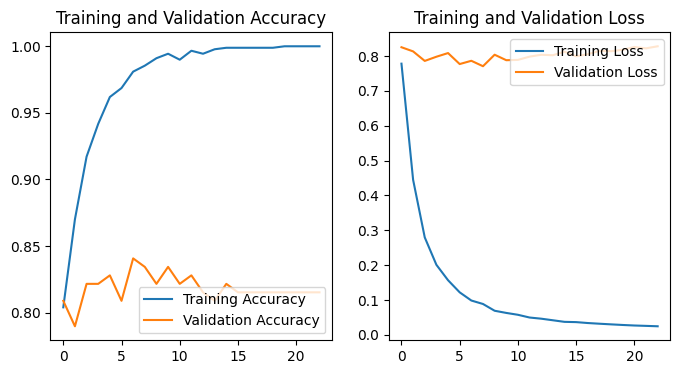

In [62]:
history = histories[model_name]
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


We can observe over-fitting because the training accuracy kept improving rapidly but the validation accuracy did not follow at all. 

## 4.7.  [&#9650;](#toc0_) <a id='toc4_7_'></a>Classification model based on mobileNet WITH data augmentation.

In [63]:
batch_size = 16
validation_split = 0.15

train_ds, val_ds = get_ds(batch_size, validation_split)

Found 1050 files belonging to 7 classes.
Using 893 files for training.
Using 157 files for validation.


In [64]:
augmented_train_ds = prepare_ds(train_ds, shuffle=True, augment=True)
val_ds = prepare_ds(val_ds)

2023-06-13 15:11:09.349630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [893]
	 [[{{node Placeholder/_4}}]]
2023-06-13 15:11:09.350462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [893]
	 [[{{node Placeholder/_4}}]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] f

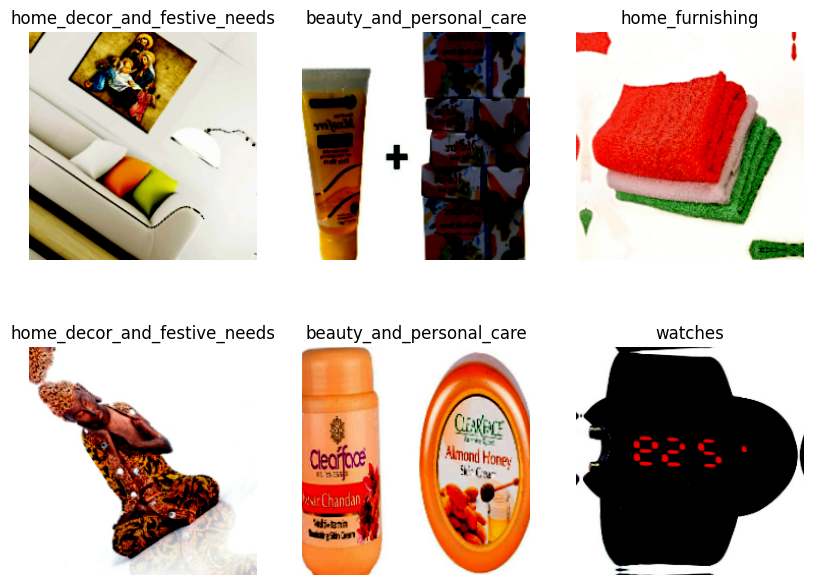

In [65]:
# visualize items of the augmented training dataset
class_names = train_ds.class_names

plt.figure(figsize=(10, 7.5))
for images, labels in augmented_train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy(), vmin=-1, vmax=1)
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [70]:
model = make_model_from_mobilenet(n_classes=7)
model_name = f'augmented_batch{batch_size}'

histories[model_name] = compile_and_fit(
    model=model,
    name=model_name,
    train_ds=augmented_train_ds,
    val_ds=val_ds,
    max_epochs=50,
)


2023-06-13 15:17:30.975010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype resource
	 [[{{node Placeholder/_28}}]]
2023-06-13 15:17:30.976013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [893]
	 [[{{node Placeholder/_4}}]]


Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 2.2545 - accuracy: 0.5095
Epoch 1: val_loss improved from inf to 1.28644, saving model to ./models/augmented_batch16
56/56 [==============================] - 36s 539ms/step - loss: 2.2545 - accuracy: 0.5095 - val_loss: 1.2864 - val_accuracy: 0.7261
Epoch 2/50
56/56 [==============================] - ETA: 0s - loss: 0.9979 - accuracy: 0.7469
Epoch 2: val_loss improved from 1.28644 to 1.07213, saving model to ./models/augmented_batch16
56/56 [==============================] - 43s 677ms/step - loss: 0.9979 - accuracy: 0.7469 - val_loss: 1.0721 - val_accuracy: 0.7771
Epoch 3/50
56/56 [==============================] - ETA: 0s - loss: 0.8488 - accuracy: 0.7749
Epoch 3: val_loss improved from 1.07213 to 1.03644, saving model to ./models/augmented_batch16
56/56 [==============================] - 44s 680ms/step - loss: 0.8488 - accuracy: 0.7749 - val_loss: 1.0364 - val_accuracy: 0.7580
Epoch 4/50
56/56 [=======================

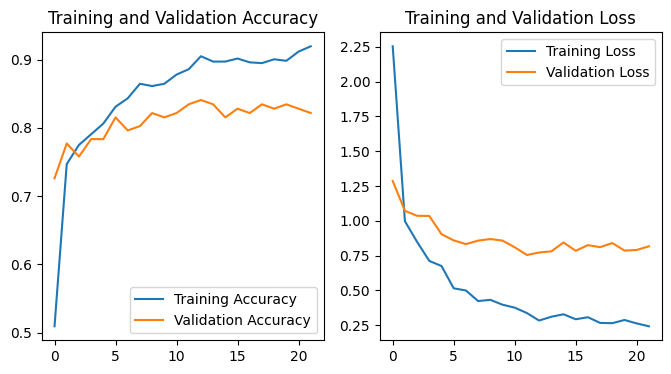

In [71]:
history = histories[model_name]
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Still very much overfitting although the effect is attenuated.

## 4.8.  [&#9650;](#toc0_) <a id='toc4_8_'></a>Classification model based on mobileNet with data augmentation + dropout 0.3

In [81]:
model = make_model_from_mobilenet(n_classes=7, summary=True, dropout=True)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 112, 112, 32)     

In [82]:
model_name = f'augmented_batch{batch_size}_dropout_03'

histories[model_name] = compile_and_fit(
    model=model,
    name=model_name,
    train_ds=augmented_train_ds,
    val_ds=val_ds,
    max_epochs=50,
)


Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 3.4125 - accuracy: 0.4737
Epoch 1: val_loss improved from inf to 1.07486, saving model to ./models/augmented_batch16_dropout_03
56/56 [==============================] - 36s 525ms/step - loss: 3.4125 - accuracy: 0.4737 - val_loss: 1.0749 - val_accuracy: 0.7261
Epoch 2/50
56/56 [==============================] - ETA: 0s - loss: 1.9327 - accuracy: 0.6327
Epoch 2: val_loss improved from 1.07486 to 0.82021, saving model to ./models/augmented_batch16_dropout_03
56/56 [==============================] - 42s 659ms/step - loss: 1.9327 - accuracy: 0.6327 - val_loss: 0.8202 - val_accuracy: 0.7898
Epoch 3/50
56/56 [==============================] - ETA: 0s - loss: 1.5612 - accuracy: 0.6943
Epoch 3: val_loss improved from 0.82021 to 0.74933, saving model to ./models/augmented_batch16_dropout_03
56/56 [==============================] - 43s 673ms/step - loss: 1.5612 - accuracy: 0.6943 - val_loss: 0.7493 - val_accuracy: 0.8089
Epoch 4/

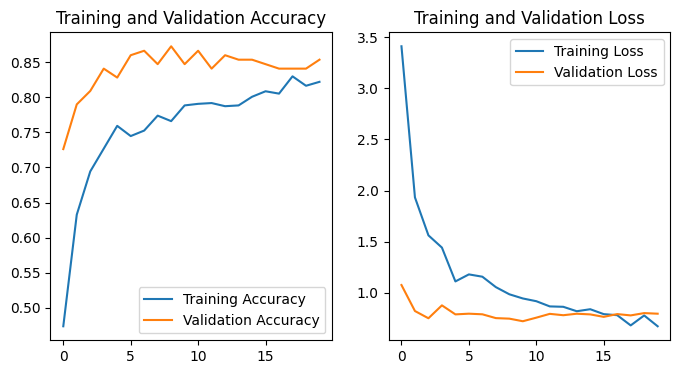

In [83]:
history = histories[model_name]
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## 4.9.  [&#9650;](#toc0_) <a id='toc4_9_'></a>Classification model based on mobileNet with data augmentation + dropout 0.5

In [84]:
model = make_model_from_mobilenet(n_classes=7, dropout=True)

In [85]:
model_name = f'augmented_batch{batch_size}_dropout_05'

histories[model_name] = compile_and_fit(
    model=model,
    name=model_name,
    train_ds=augmented_train_ds,
    val_ds=val_ds,
    max_epochs=50,
)


Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 5.0550 - accuracy: 0.3684
Epoch 1: val_loss improved from inf to 1.37814, saving model to ./models/augmented_batch16_dropout_05
56/56 [==============================] - 35s 513ms/step - loss: 5.0550 - accuracy: 0.3684 - val_loss: 1.3781 - val_accuracy: 0.6624
Epoch 2/50
56/56 [==============================] - ETA: 0s - loss: 2.7508 - accuracy: 0.5879
Epoch 2: val_loss improved from 1.37814 to 1.07944, saving model to ./models/augmented_batch16_dropout_05
56/56 [==============================] - 40s 629ms/step - loss: 2.7508 - accuracy: 0.5879 - val_loss: 1.0794 - val_accuracy: 0.7771
Epoch 3/50
56/56 [==============================] - ETA: 0s - loss: 2.3485 - accuracy: 0.6473
Epoch 3: val_loss improved from 1.07944 to 1.04124, saving model to ./models/augmented_batch16_dropout_05
56/56 [==============================] - 47s 735ms/step - loss: 2.3485 - accuracy: 0.6473 - val_loss: 1.0412 - val_accuracy: 0.8217
Epoch 4/

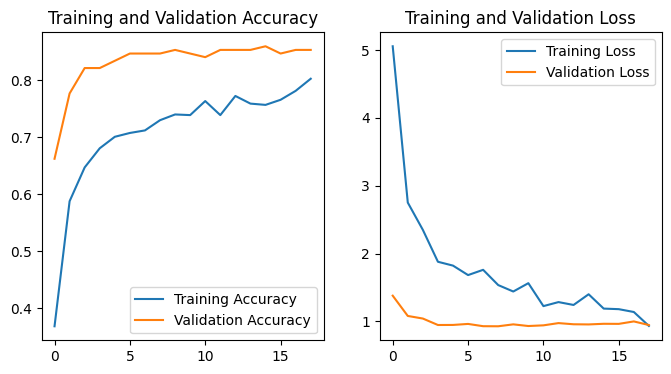

In [86]:
history = histories[model_name]
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [94]:
history_dir = './histories'
if not os.path.exists(history_dir):
    os.mkdir(history_dir)

for model_name, history in histories.items():
    np.save(
        os.path.join(history_dir, model_name + '_history.npy'),
        history.history
    )

In [100]:
# filename = os.path.join(history_dir, model_name + '_history.npy')
# loaded_history = np.load(filename, allow_pickle=True).item()

## 4.10.  [&#9650;](#toc0_) <a id='toc4_10_'></a>Visualize results

In [106]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-dusup3ho
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-dusup3ho
  Resolved https://github.com/tensorflow/docs to commit 2640af9a586e1e9a2c6cc2a1d52cf21ff9392f2c
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.5.26.9808-py3-none-any.whl size=183624 sha256=4f91ecc797499b42379d9b523476ed9eb9cb19d92eb8fe139c7e6efc8b325d77
  Stored in directory: /tmp/pip-ephem-wheel-cache-5fwnfpha/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


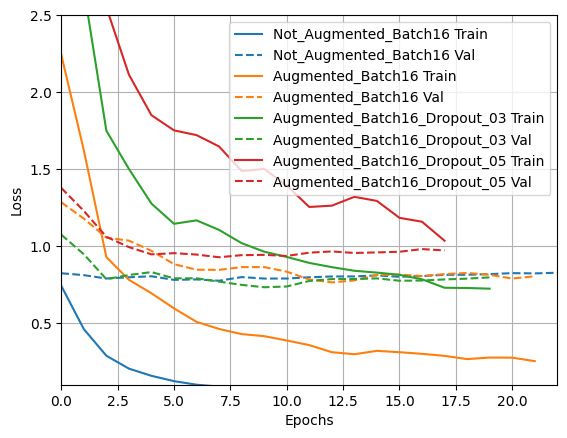

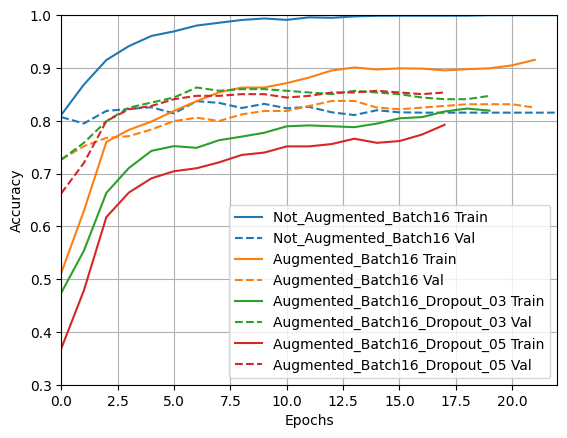

In [128]:
import tensorflow_docs as tfdocs 
import tensorflow_docs.plots
from  IPython import display

loss_plotter = tfdocs.plots.HistoryPlotter(metric='loss', smoothing_std=20)
loss_plotter.plot(histories)
# a = plt.xscale('log')
plt.xlim([0, max(plt.xlim())])
plt.ylim([0.1, 2.5])
plt.xlabel("Epochs")
plt.show()

acc_plotter = tfdocs.plots.HistoryPlotter(metric='accuracy', smoothing_std=20)
acc_plotter.plot(histories)
# a = plt.xscale('log')
plt.xlim([0, max(plt.xlim())])
plt.ylim([0.3, 1])
plt.xlabel("Epochs")
plt.show()


In [108]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/

# 5.  [&#9650;](#toc0_) <a id='toc5_'></a>Regularizations

In [67]:
from tensorflow.keras import regularizers

In [73]:
for images, labels in train_ds.unbatch().batch(32).take(1):
    print(images.shape)
    print(labels.shape)

2023-06-13 12:19:09.954382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [945]
	 [[{{node Placeholder/_0}}]]
2023-06-13 12:19:09.954918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [945]
	 [[{{node Placeholder/_4}}]]


(32, 224, 224, 3)
(32, 7)
